<a href="https://colab.research.google.com/github/yashkulkarni45/CSI-AI-ML/blob/main/Fake_News_Detection_EDAI_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Loading the Dataset

In [3]:
df_true = pd.read_csv("/content/True.csv")
df_fake = pd.read_csv("/content/Fake.csv")

Setting up a target and merging both datasets

In [4]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,target,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


Checking the number of null values

In [5]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

Some Data cleaning

In [6]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)

    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

EXPLORATORY DATA ANALYSIS - EDA

1. Distribution of true and fake news

In [8]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

2. What issues have been most covered in the news?

In [9]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

3. Word Cloud

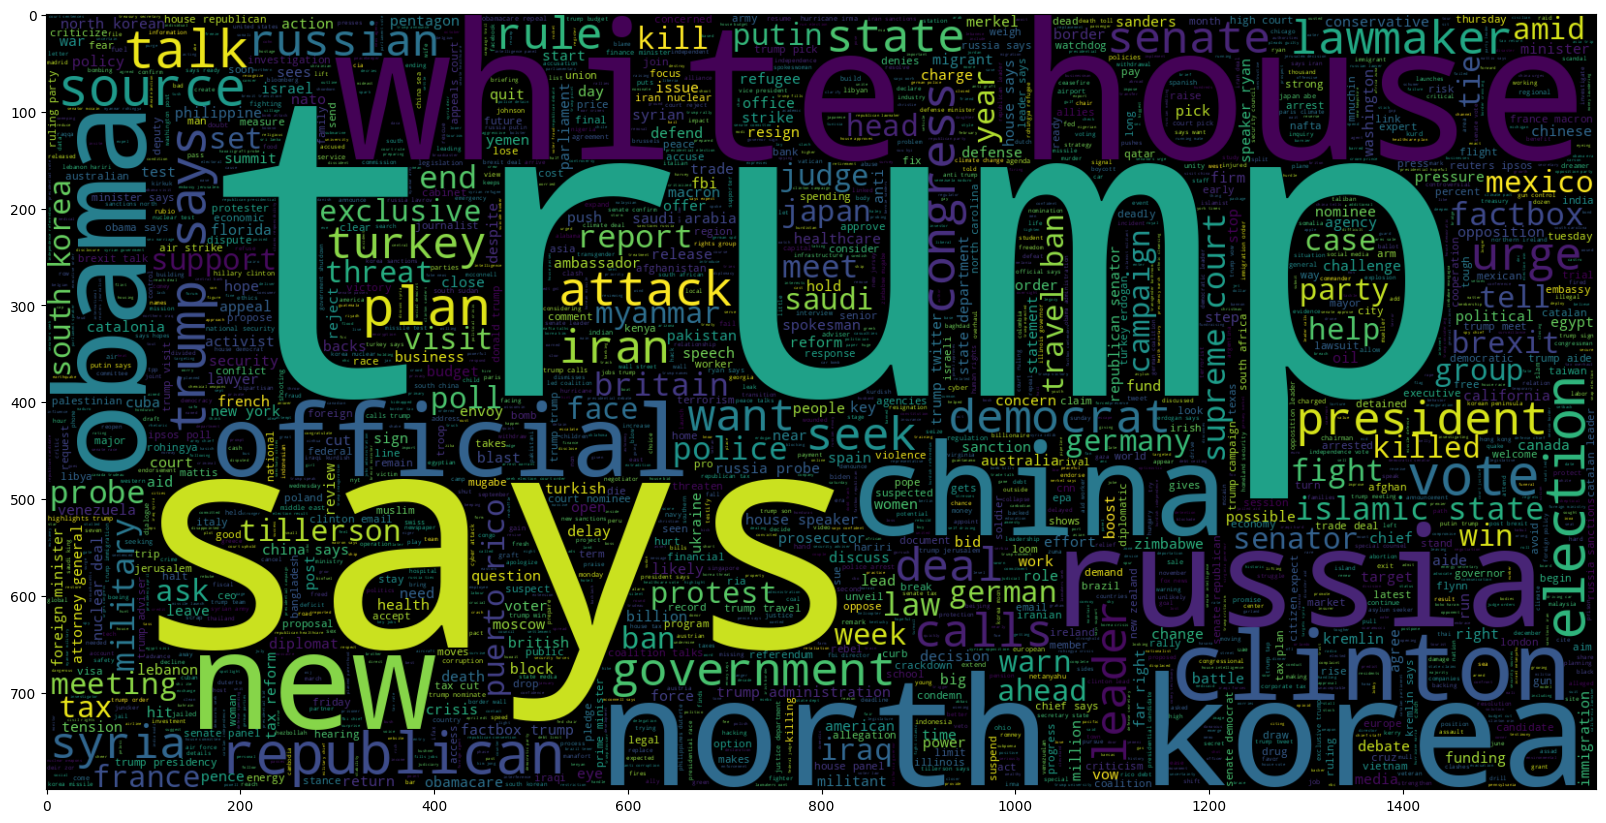

In [10]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

4. Maximum count of words in a title

In [11]:
nltk.download('punkt')
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The maximum number of words in a title is = 34


In [12]:
df

,title,text,subject,date,target,original,clean_title,clean_joined_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,PoliticsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal script
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,PoliticsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,PoliticsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, let, mueller, job]",senior republican senator let mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,PoliticsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,PoliticsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailors
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls quits


Data Preprocessing

In [30]:
import re
def wordopt(text):
    #text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df["text"] = df["text"].apply(wordopt)

Model Building

Train test split

In [14]:
x = df["text"]
y = df["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

LOGISTIC REGRESSION

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5855
           1       0.99      0.99      0.99      5370

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



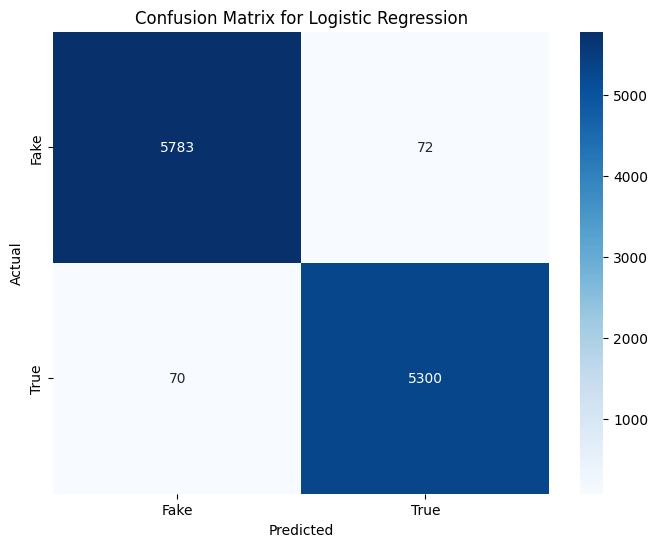

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train,y_train)

pred_lr=LR.predict(xv_test)
LR.score(xv_test, y_test)

print(classification_report(y_test, pred_lr))

confusion_mat = confusion_matrix(y_test, pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Decision Tree Classifier

Accuracy: 99.65%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5855
           1       1.00      1.00      1.00      5370

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



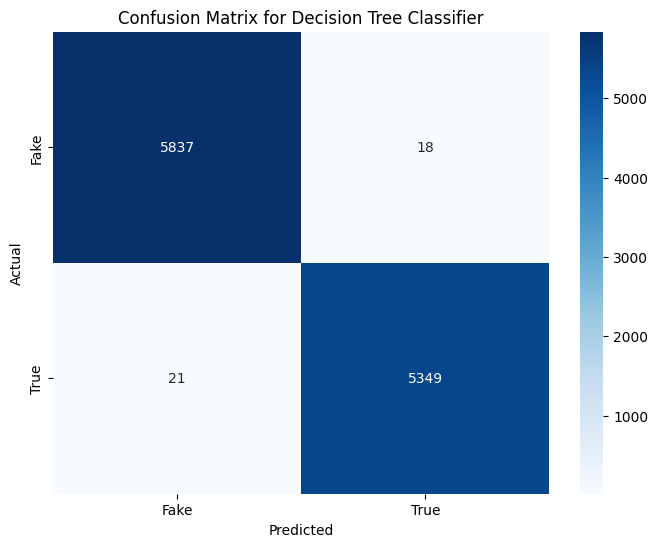

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

pred_dt = DT.predict(xv_test)
accuracy = DT.score(xv_test, y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(y_test, pred_dt))

confusion_mat = confusion_matrix(y_test, pred_dt)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

Gradient Boosting Classifier

Accuracy: 99.61%
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5855
           1       0.99      1.00      1.00      5370

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



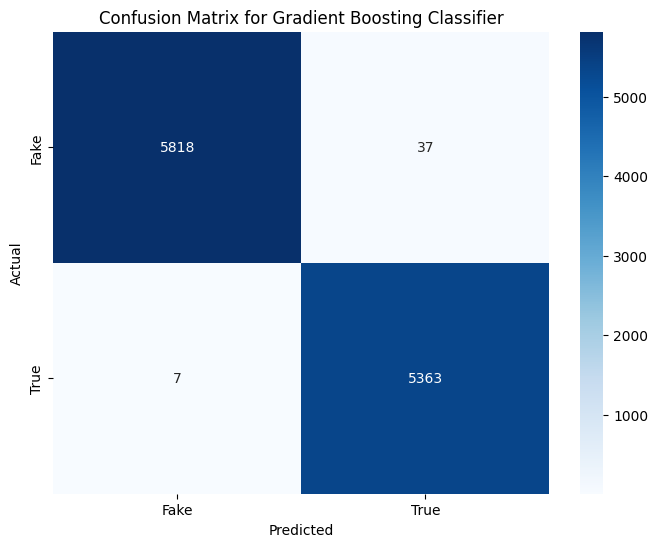

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(xv_train, y_train)

pred_gbc = GBC.predict(xv_test)
accuracy = GBC.score(xv_test, y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(y_test, pred_gbc))

confusion_mat = confusion_matrix(y_test, pred_gbc)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plt.show()

Random Forest Classfier

Accuracy: 99.06%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5855
           1       0.99      0.99      0.99      5370

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



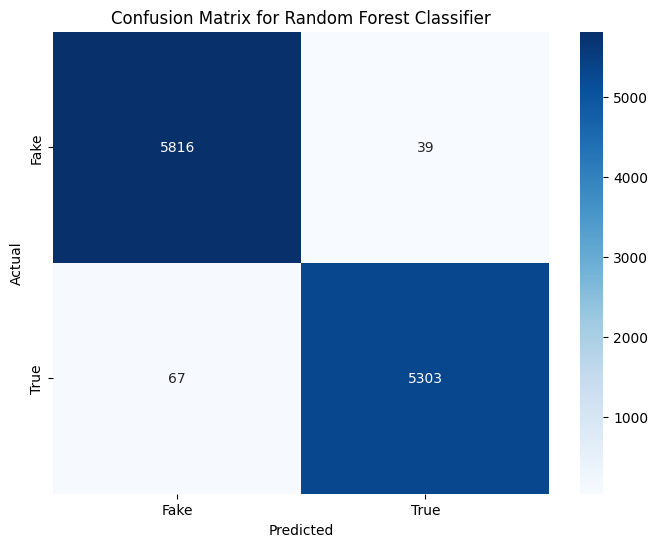

In [18]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

pred_rfc = RFC.predict(xv_test)
accuracy = RFC.score(xv_test, y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(y_test, pred_rfc))

confusion_mat = confusion_matrix(y_test, pred_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

Taking Manual Inputs

In [33]:
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"

def manual_testing(news):
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
    pred_DT = DT.predict(new_xv_test)
    pred_GBC = GBC.predict(new_xv_test)
    pred_RFC = RFC.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \nDT Prediction: {} \nGBC Prediction: {} \nRFC Prediction: {}".format(output_lable(pred_LR[0]),                                                                                                       output_lable(pred_DT[0]),
                                                                                                              output_lable(pred_GBC[0]),
                                                                                                              output_lable(pred_RFC[0])))



Hindi to English news translation

In [21]:
!pip3 uninstall googletrans
!pip3 install googletrans==3.1.0a0
from googletrans import Translator, constants
from pprint import pprint

def translation (text):

 translator = Translator()

 translation = translator.translate(text, dest="en")
 print(translation.text)

Found existing installation: googletrans 3.1.0a0
Uninstalling googletrans-3.1.0a0:
  Would remove:
    /usr/local/bin/translate
    /usr/local/lib/python3.10/dist-packages/googletrans-3.1.0a0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/googletrans/*
Proceed (Y/n)? Y
  Successfully uninstalled googletrans-3.1.0a0
  Using cached googletrans-3.1.0a0-py3-none-any.whl


Passing the translated English text to check if the news is fake or not

In [ ]:
#manual_testing(translation.text)

Giving user a menu

In [38]:
#@title Fake News Detection

text = 'New Delhi: An agreement has been reached between America and China on nuclear arms control talks (US China On Nuclear Arms Control). This conversation between the two will take place next week. According to Reuters news, this information was given by the Wall Street Journal on Wednesday. He told that China has agreed to organize nuclear arms control talks with America. For the first time after the Obama government leaves power, there will be talks between China and America on nuclear arms control. But there will be an agreement between the two on limiting nuclear weapons.' #@param {type:"string"}
dropdown = 'English' #@param ["English","Hindi"]

if dropdown == 'English':
  manual_testing(text)
else:
  new_text = str(translation(text))
  print(new_text)
  manual_testing(new_text)



LR Prediction: Not A Fake News 
DT Prediction: Not A Fake News 
GBC Prediction: Not A Fake News 
RFC Prediction: Not A Fake News
